In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.set_style("white")
sns.set_style("ticks")
import matplotlib
import scanpy as sc
import anndata
sc.settings.set_figure_params(dpi=100, facecolor='white')
from matplotlib import rcParams
plt.rcParams['axes.grid'] = False
import sys
%matplotlib inline
sc.logging.print_header()
import warnings
warnings.filterwarnings('ignore')
import rnaseqTools
os.chdir('../')

scanpy==1.9.1 anndata==0.9.1 umap==0.5.3 numpy==1.21.6 scipy==1.9.1 pandas==1.4.4 scikit-learn==1.3.2 statsmodels==0.14.1 python-igraph==0.10.4 pynndescent==0.5.10


In [2]:
adata = sc.read_h5ad("10x_cn_neuron_mtx/cn_neurons.h5ad")
pseq = sc.read_h5ad('patchseq_mtx/patchseq.dataset.final.h5ad')

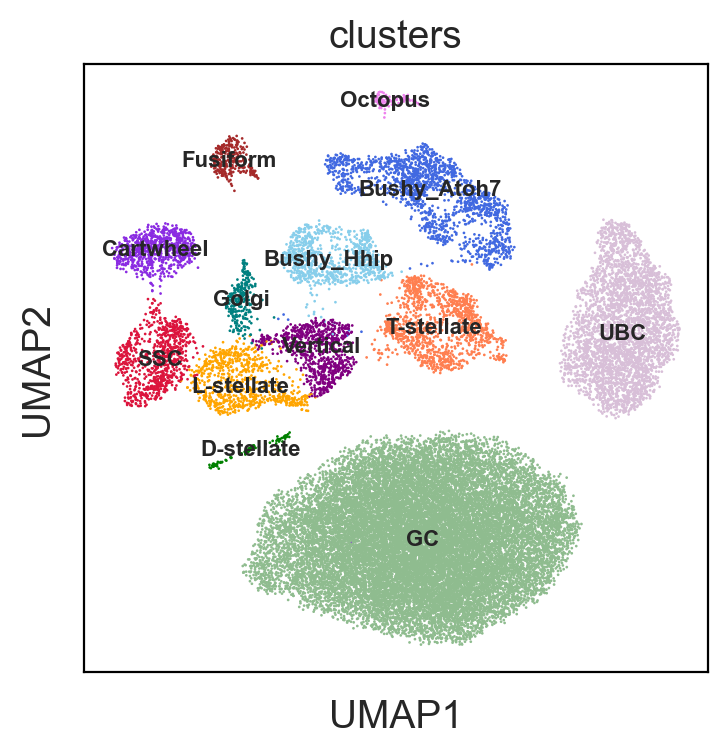

In [3]:
rcParams['figure.figsize'] = 4, 4
sc.pl.umap(adata, color = 'clusters',legend_loc = 'on data', legend_fontsize=8)

Chosen offset: 0.34


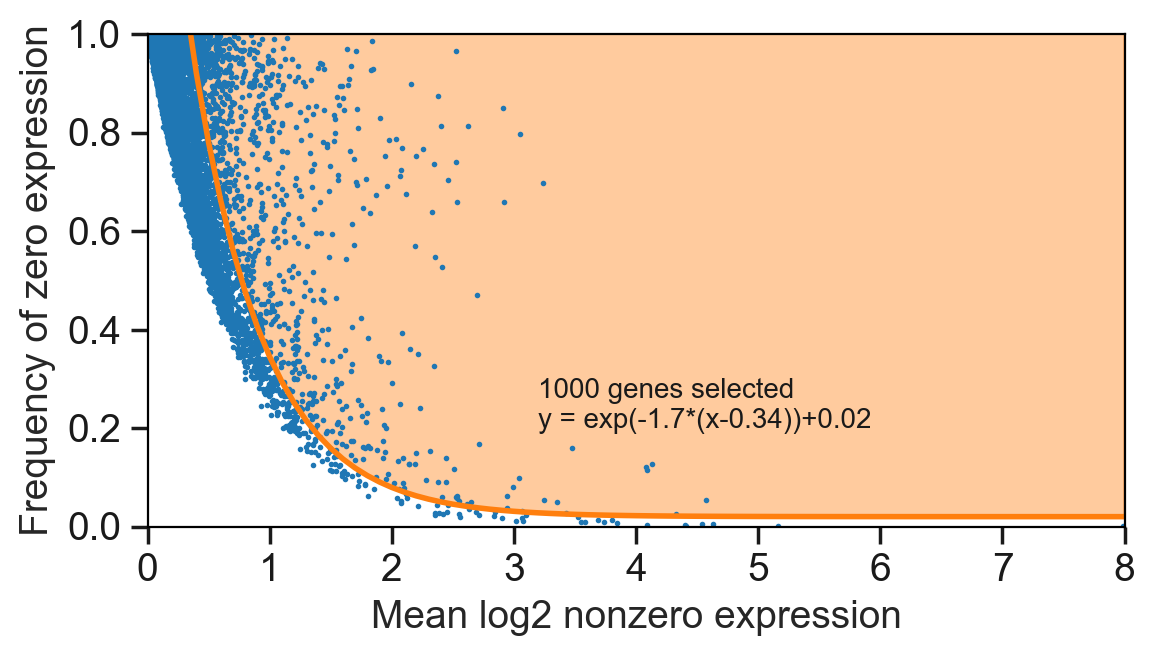

In [4]:
genesForRRR  = rnaseqTools.geneSelection(adata.layers['counts'], n=1000, threshold= 0.0, decay=1.7)## test n=1000,2000,3000

In [5]:
ref_count = adata.layers['counts'][:, genesForRRR]
ref_gene = adata[:, genesForRRR].var_names
location = adata.obsm['X_umap']
pseq_count = pseq.layers['counts']
pseq_gene = pseq.var_names

In [6]:
mapped_pos = rnaseqTools.map_to_tsne(ref_count,ref_gene,
                              pseq_count,pseq_gene,
                              location, 
                              bootstrap = True, knn = 10,seed = 1)

Using a common set of 997 genes.
Bootstrapping.................................................................................................... done


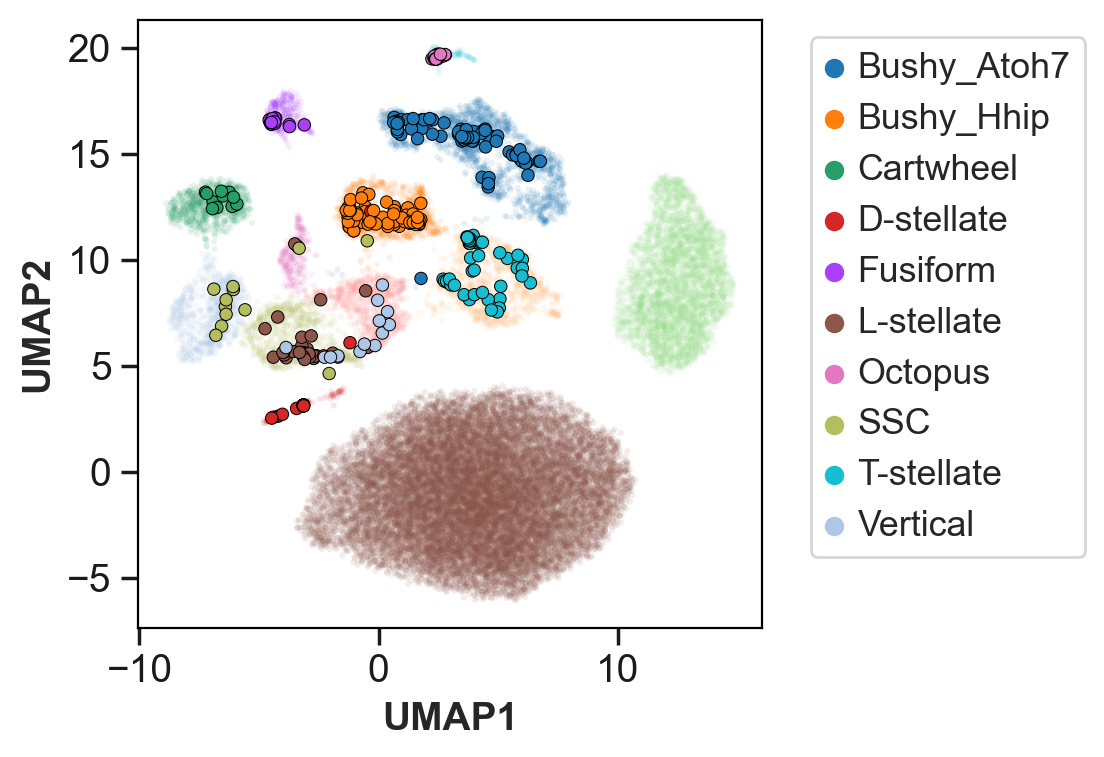

In [7]:
rcParams['figure.figsize'] = 4, 4
sns.scatterplot(adata.obsm['X_umap'][:,0],adata.obsm['X_umap'][:,1],s = 5,
                    hue = adata.obs['clusters'],
                    edgecolor="none",
                    alpha = 0.1,legend = False)

sns.scatterplot(mapped_pos[0][:,0],mapped_pos[0][:,1],s = 20,
                    hue = pseq.obs['T-cluster'],
                    edgecolor="black",
                    alpha = 1,legend = True)
plt.xlabel("UMAP1", fontweight ='bold',size=14)
plt.ylabel("UMAP2", fontweight ='bold',size=14)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

## Selected highly variable genes with scanpy

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes = 1000, flavor = 'cell_ranger', batch_key = 'sample')

In [9]:
ref_count = adata.raw.X[:, adata.var.highly_variable]
ref_gene = adata[:, adata.var.highly_variable].var_names
location = adata.obsm['X_umap']
pseq_count = pseq.raw.X
pseq_gene = pseq.var_names

In [10]:
mapped_pos = rnaseqTools.map_to_tsne(ref_count,ref_gene,
                              pseq_count,pseq_gene,
                              location, 
                              bootstrap = True, knn = 10,seed = 1)

Using a common set of 997 genes.
Bootstrapping.................................................................................................... done


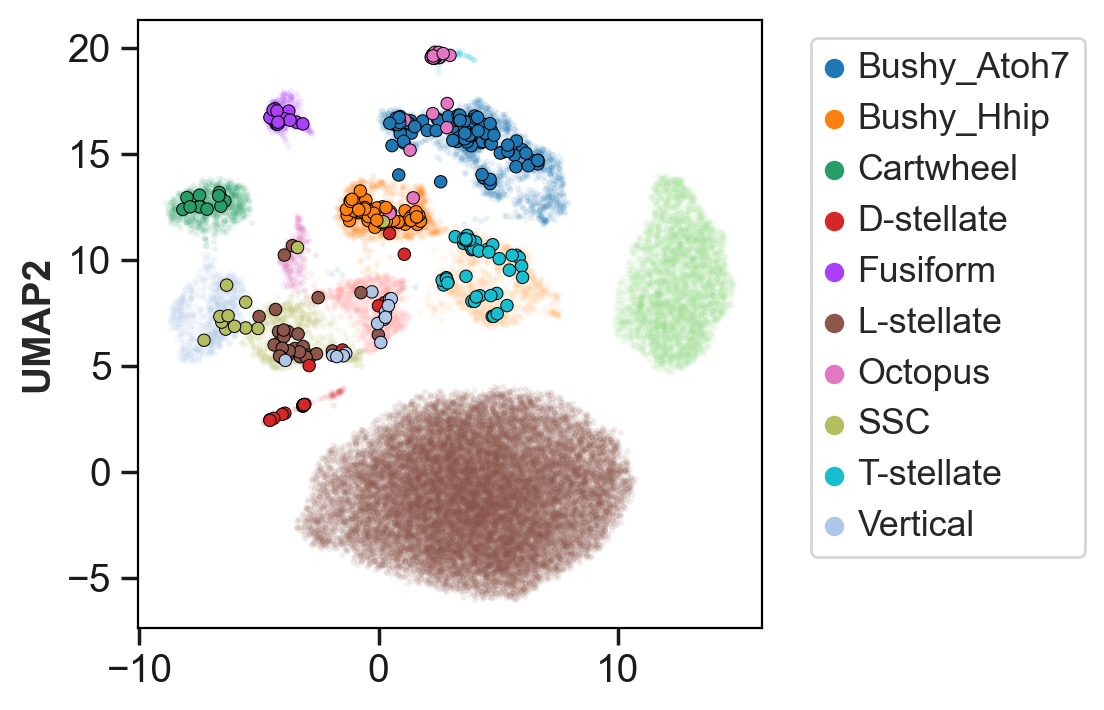

In [11]:
rcParams['figure.figsize'] = 4, 4
sns.scatterplot(adata.obsm['X_umap'][:,0],adata.obsm['X_umap'][:,1],s = 5,
                    hue = adata.obs['clusters'],
                    edgecolor="none",
                    alpha = 0.1,legend = False)

sns.scatterplot(mapped_pos[0][:,0],mapped_pos[0][:,1],s = 20,
                    hue = pseq.obs['T-cluster'],
                    edgecolor="black",
                    alpha = 1,legend = True)
plt.ylabel("UMAP2", fontweight ='bold',size=14)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

## Select gene list with top genes in each cluster

In [12]:
sc.tl.rank_genes_groups(adata, 'clusters', method='t-test_overestim_var')

In [13]:
marker = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(50)## top 100 in each cluster
gene_list = []
for i in list(marker.columns):
    gene_list = (set(gene_list) | set(marker[i]))
gene_list = list(gene_list)
adata.var['selected'] =  False
for gene in gene_list:
    adata.var.selected[gene] = True

Using a common set of 358 genes.
Bootstrapping.................................................................................................... done


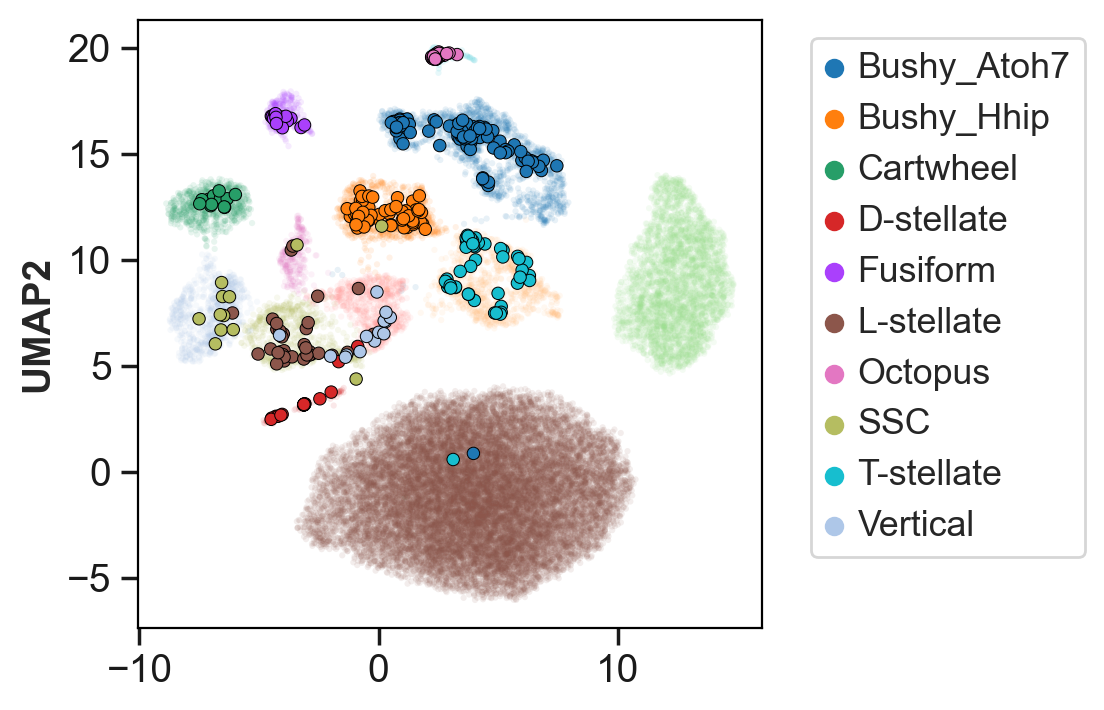

In [14]:
ref_count = adata.raw.X[:, adata.var.selected]
ref_gene = adata[:, adata.var.selected].var_names
location = adata.obsm['X_umap']
pseq_count = pseq.raw.X
pseq_gene = pseq.var_names
mapped_pos = rnaseqTools.map_to_tsne(ref_count,ref_gene,
                              pseq_count,pseq_gene,
                              location, 
                              bootstrap = True, knn = 10,seed = 1)
rcParams['figure.figsize'] = 4, 4
sns.scatterplot(adata.obsm['X_umap'][:,0],adata.obsm['X_umap'][:,1],s = 5,
                    hue = adata.obs['clusters'],
                    edgecolor="none",
                    alpha = 0.1,legend = False)

sns.scatterplot(mapped_pos[0][:,0],mapped_pos[0][:,1],s = 20,
                    hue = pseq.obs['T-cluster'],
                    edgecolor="black",
                    alpha = 1,legend = True)
plt.ylabel("UMAP2", fontweight ='bold',size=14)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

## mapping correlations of each celll to assigned clusters

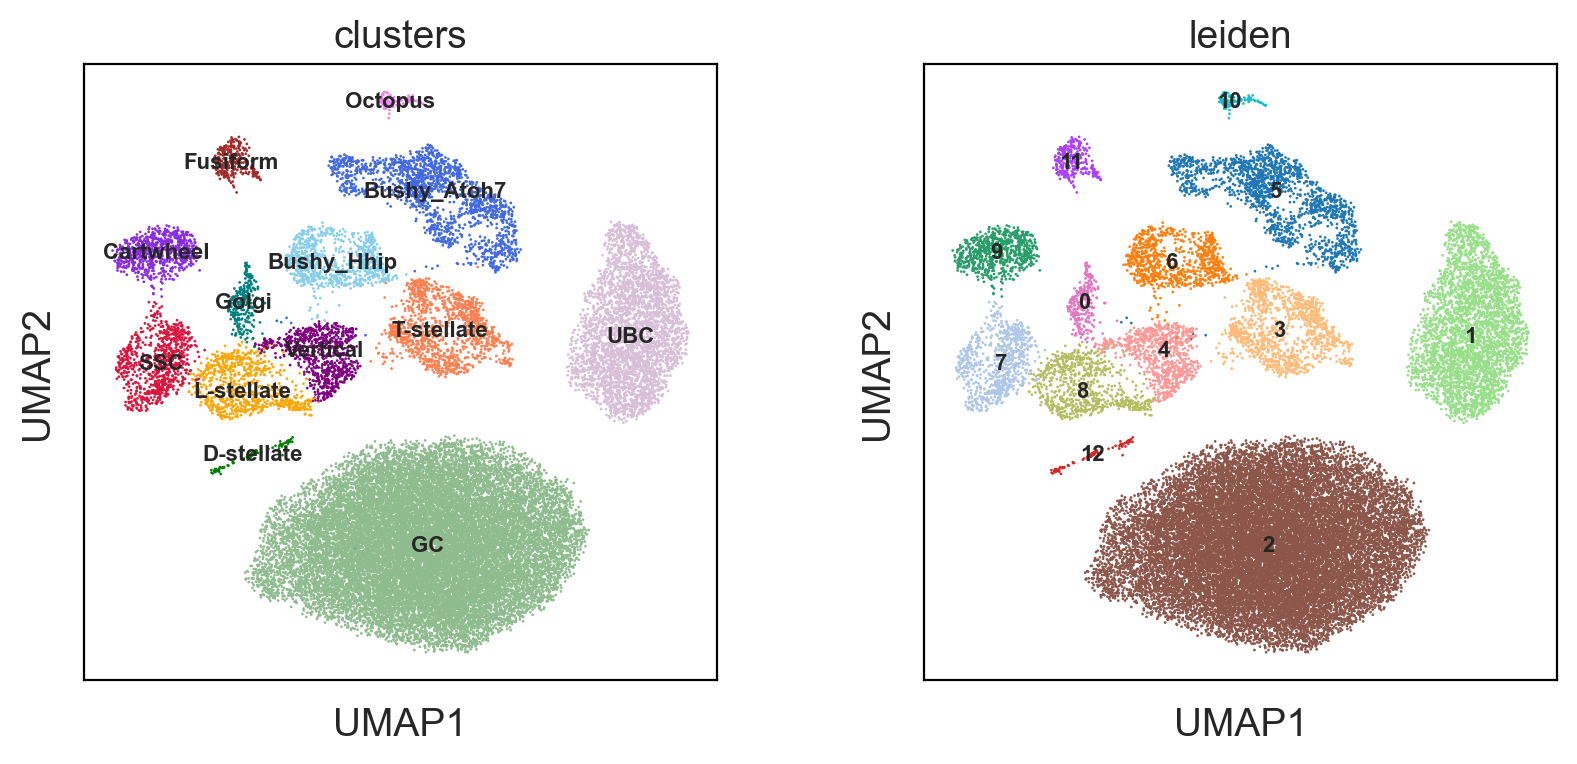

In [15]:
adata.obs['leiden'] = (
    adata.obs["clusters"]
    .map(lambda x: {'Golgi':'0','UBC':'1',
         'GC':'2','T-stellate':'3',
         'Vertical':'4','Bushy_Atoh7':'5',
         'Bushy_Hhip':'6','SSC':'7',
         'L-stellate':'8', 'Cartwheel':'9',
          'Octopus':'10','Fusiform':'11',
         'D-stellate':'12'
                   }.get(x, x))
    .astype("category"))

sc.pl.umap(adata, color =['clusters','leiden'],legend_loc = 'on data', legend_fontsize=8)


In [16]:
cluster = adata.obs['leiden'].astype(int).values
clusterAssignment, Cmeans = rnaseqTools.map_to_clusters(ref_count,ref_gene,
                              pseq_count,pseq_gene,
                              cluster,
                              bootstrap = True)

Using a common set of 358 genes.
.................................................................................................... done


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


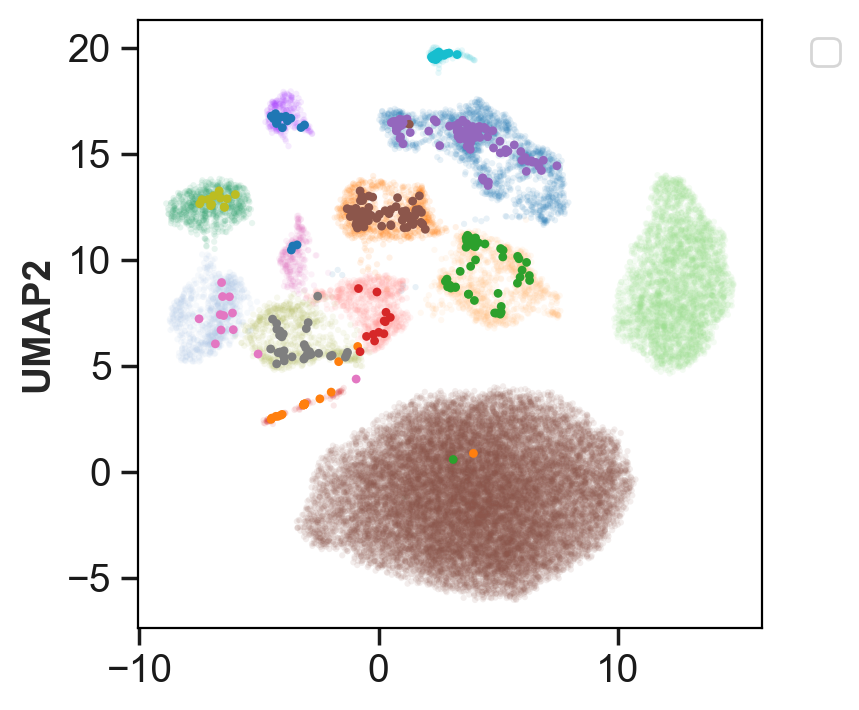

In [17]:
rcParams['figure.figsize'] = 4, 4
sns.scatterplot(adata.obsm['X_umap'][:,0],adata.obsm['X_umap'][:,1],s = 5,
                    hue = adata.obs['clusters'],
                    edgecolor="none",
                    alpha = 0.1,legend = False)

sns.scatterplot(mapped_pos[0][:,0],mapped_pos[0][:,1],s = 10,
                    hue = clusterAssignment,
                    palette= 'tab10',
                    edgecolor="none",
                    alpha = 1,legend = False)
plt.ylabel("UMAP2", fontweight ='bold',size=14)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [18]:
df = pd.DataFrame(Cmeans, index = pseq.obs_names, columns =['Golgi','UBC',
         'GC','T-stellate',
         'Vertical','Bushy_Atoh7',
         'Bushy_Hhip','SSC',
         'L-stellate', 'Cartwheel',
          'Octopus','Fusiform',
         'D-stellate'])

(0.0, 1.2)

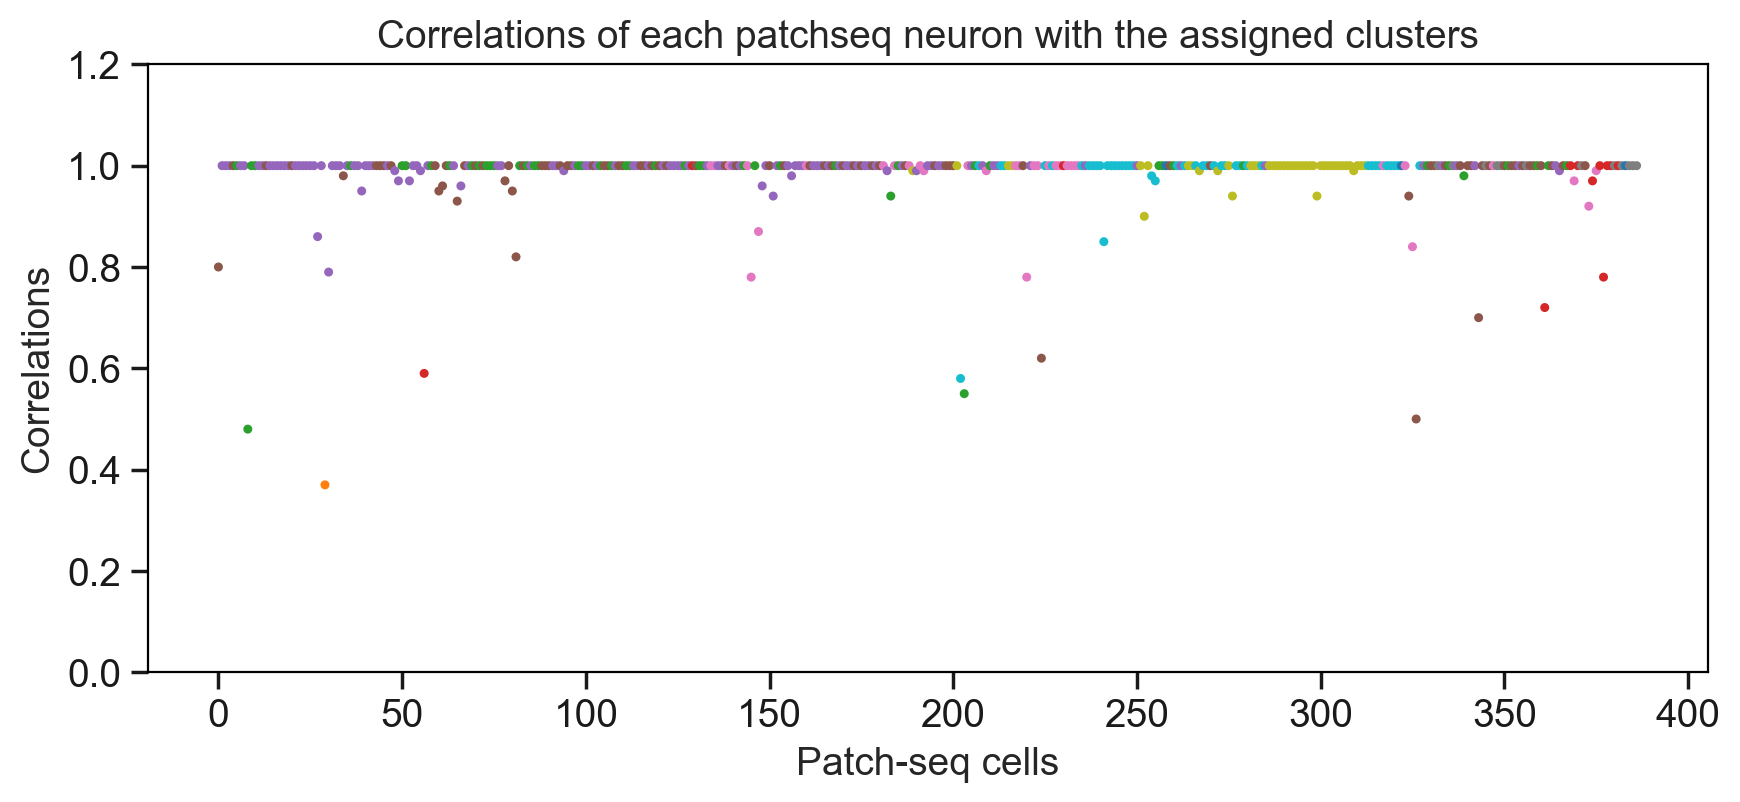

In [19]:
rcParams['figure.figsize'] = 10, 4
plt.scatter(x = range(len(pseq.obs_names)),y = df.T.max(),s = 5, c = clusterAssignment, cmap ='tab10')
plt.ylabel('Correlations')
plt.xlabel('Patch-seq cells')
plt.title("Correlations of each patchseq neuron with the assigned clusters")
plt.ylim([0, 1.2])